Assignment
In this assignment, you'll continue working with the U.S. Education Dataset from Kaggle. The data gives detailed state level information on the several facets of the state of education on annual basis. To learn more about the data and the column descriptions, you can view the Kaggle link above. You should access the data from the Thinkful database. Below are the credentials you can use to connect to the database:

https://www.kaggle.com/noriuk/us-education-datasets-unification-project

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

Don't forget to apply the most suitable missing value filling techniques you applied in the previous checkpoints to the data. You should provide your answers to the following questions after you handled the missing values.

To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

Say, we want to understand the relationship between the expenditures of the governments and the students' overall success in the math and reading.

1. Create a new score variable from the weighted averages of all score variables in the datasets. Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!.
2. What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?
3. Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?
4. What is the correlation between the overall score variable and the 1st principal component?
5. If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

In [19]:
%matplotlib inline
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as stats

warnings.filterwarnings('ignore')

In [20]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from useducation',con=engine)
engine.dispose()

In [21]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     1492 non-null object
STATE                           1492 non-null object
YEAR                            1492 non-null int64
ENROLL                          1229 non-null float64
TOTAL_REVENUE                   1280 non-null float64
FEDERAL_REVENUE                 1280 non-null float64
STATE_REVENUE                   1280 non-null float64
LOCAL_REVENUE                   1280 non-null float64
TOTAL_EXPENDITURE               1280 non-null float64
INSTRUCTION_EXPENDITURE         1280 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1280 non-null float64
OTHER_EXPENDITURE               1229 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1280 non-null float64
GRADES_PK_G                     1319 non-null float64
GRADES_KG_G                     1360 non-null float64
GRADES_4_G                      1361 non-null float64
GRADES_8_G                      1

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


0. Don't forget to apply the most suitable missing value filling techniques you applied in the previous checkpoints to the data. You should provide your answers to the following questions after you handled the missing values.

In [33]:
# perform interpolation fillna within states, then dropna
df_fill = df.copy()
for col in df_fill.columns:
    if col not in ['PRIMARY_KEY', 'STATE', 'YEAR']:
        for state in df_fill.STATE.unique():
            df_fill.loc[df_fill.STATE==state, col] = df_fill[df_fill.STATE==state][col].interpolate()
# df_fill = df_fill.dropna()
df_fill.dropna(inplace=True)

df_fill.info()
df_fill.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1046 entries, 54 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     1046 non-null object
STATE                           1046 non-null object
YEAR                            1046 non-null int64
ENROLL                          1046 non-null float64
TOTAL_REVENUE                   1046 non-null float64
FEDERAL_REVENUE                 1046 non-null float64
STATE_REVENUE                   1046 non-null float64
LOCAL_REVENUE                   1046 non-null float64
TOTAL_EXPENDITURE               1046 non-null float64
INSTRUCTION_EXPENDITURE         1046 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1046 non-null float64
OTHER_EXPENDITURE               1046 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1046 non-null float64
GRADES_PK_G                     1046 non-null float64
GRADES_KG_G                     1046 non-null float64
GRADES_4_G                      1046 non-null float64
GRADES_8_G                      

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
54,1993_ARIZONA,ARIZONA,1993,676297.0,3427976.0,318465.0,1415407.0,1694104.0,3623946.0,1578889.0,...,57701.0,53500.0,37614.0,461398.0,182737.0,647299.0,215.834434,265.993417,206.291984,262.448330
55,1993_ARKANSAS,ARKANSAS,1993,311432.0,1346909.0,128196.0,771079.0,447634.0,1376067.0,782791.0,...,34255.0,36471.0,27169.0,280280.0,125801.0,407329.0,211.616130,257.647254,208.685273,266.423396
57,1993_COLORADO,COLORADO,1993,539538.0,3058326.0,147793.0,1242337.0,1668196.0,3028305.0,1537714.0,...,50807.0,47665.0,34770.0,403871.0,164260.0,575380.0,222.219036,273.200878,215.523979,266.856804
58,1993_CONNECTICUT,CONNECTICUT,1993,471918.0,4064158.0,149204.0,1433539.0,2481415.0,4079943.0,2302852.0,...,39093.0,34662.0,27979.0,310022.0,127655.0,443893.0,228.105503,275.202320,224.712775,264.457874
59,1993_DELAWARE,DELAWARE,1993,104355.0,683954.0,44497.0,443250.0,196207.0,694534.0,394680.0,...,8285.0,8265.0,5882.0,67899.0,28930.0,97394.0,217.181255,263.834857,207.792430,262.255809


1. Create a new score variable from the weighted averages of all score variables in the datasets. Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!.

ANS: didn't mention what's the weight for every score. Is it just take average, or it is talking about weighted considering enroll students number as well? I used the latter one to calculate the weighted score. and then take average between math and reading

In [34]:
# didn't mention what's the weight for every score, so just take average
df_fill['weighted_average_score'] = (df_fill['AVG_MATH_4_SCORE']* df_fill['GRADES_4_G'] + df_fill['AVG_MATH_8_SCORE']*df_fill['GRADES_8_G'] \
                                + df_fill['AVG_READING_4_SCORE']* df_fill['GRADES_4_G'] + df_fill['AVG_READING_8_SCORE']*df_fill['GRADES_8_G'])\
                                /(df_fill['GRADES_4_G']+df_fill['GRADES_8_G'])/2

df_fill.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,weighted_average_score
54,1993_ARIZONA,ARIZONA,1993,676297.0,3427976.0,318465.0,1415407.0,1694104.0,3623946.0,1578889.0,...,53500.0,37614.0,461398.0,182737.0,647299.0,215.834434,265.993417,206.291984,262.448330,236.637935
55,1993_ARKANSAS,ARKANSAS,1993,311432.0,1346909.0,128196.0,771079.0,447634.0,1376067.0,782791.0,...,36471.0,27169.0,280280.0,125801.0,407329.0,211.616130,257.647254,208.685273,266.423396,236.905842
57,1993_COLORADO,COLORADO,1993,539538.0,3058326.0,147793.0,1242337.0,1668196.0,3028305.0,1537714.0,...,47665.0,34770.0,403871.0,164260.0,575380.0,222.219036,273.200878,215.523979,266.856804,243.634022
58,1993_CONNECTICUT,CONNECTICUT,1993,471918.0,4064158.0,149204.0,1433539.0,2481415.0,4079943.0,2302852.0,...,34662.0,27979.0,310022.0,127655.0,443893.0,228.105503,275.202320,224.712775,264.457874,246.815311
59,1993_DELAWARE,DELAWARE,1993,104355.0,683954.0,44497.0,443250.0,196207.0,694534.0,394680.0,...,8265.0,5882.0,67899.0,28930.0,97394.0,217.181255,263.834857,207.792430,262.255809,237.735539


2. What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?

ANS: there are 4 expenditure types, let's first visulize the correlation using scatter plot, then calculate the pearsonr
INSTRUCTION_EXPENDITURE, SUPPORT_SERVICES_EXPENDITURE, OTHER_EXPENDITURE, CAPITAL_OUTLAY_EXPENDITURE 
INSTRUCTION_EXPENDITURE is slightly higher than the rest with cc = 0.10578725976081392

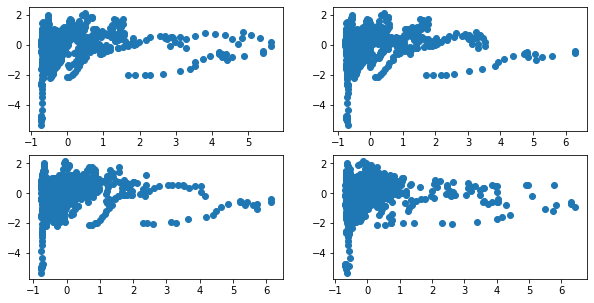

1. INSTRUCTION_EXPENDITURE- WEIGHTED         CC: (0.10578725976081392, 0.00061053105168233)
2. SUPPORT_SERVICES_EXPENDITURE- WEIGHTED    CC: (0.09864266133458902, 0.0014018399339561084)
3. OTHER_EXPENDITURE- WEIGHTED               CC: (0.02763539605825499, 0.37191945447065633)
4. CAPITAL_OUTLAY_EXPENDITURE- WEIGHTED      CC: (0.010669860541716314, 0.7303341960097909)


In [24]:
expenditure_list = ['INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE',\
                   'weighted_average_score']

# standardize the columns
for col_name in expenditure_list:
    df_fill[col_name + '_Z'] = (df_fill[col_name] - df_fill[col_name].mean())/df_fill[col_name].std()

# scatter plot
plt.figure(figsize=(10, 5))
for expend, index in zip(expenditure_list, range(len(expenditure_list)-1)):
    plt.subplot(2,2, index+1)
    plt.scatter(df_fill[expend+'_Z'], df_fill.weighted_average_score_Z)
plt.show()

# calculate correlation coefficient using pearsonr
for expend, index in zip(expenditure_list, range(len(expenditure_list)-1)):
    print("{}. {:40s}  CC: {}".format(index+1, expend + '- WEIGHTED', stats.pearsonr(df_fill[expend+'_Z'], df_fill.weighted_average_score_Z)))

3. Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?

ANS: step1, standardize to get Xc, 
step2, calculate eigen-val, eigen-vec
step3, calcluate the variance percentage from step2

the 1st component explained ratio is 0.94568116 

In [25]:
import sklearn.preprocessing
import sklearn.decomposition

X = df_fill[['INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']].copy()
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = sklearn.preprocessing.StandardScaler().fit_transform(X)

# substaniate a PCA object
sklearn_pca = sklearn.decomposition.PCA(n_components=4)
Y_sklearn = sklearn_pca.fit_transform(X)

# calculate
print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)


The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.94568116 0.03236148 0.01858226 0.00337511]


4. What is the correlation between the overall score variable and the 1st principal component?

ANS: calculate the correlation between 1st component and overall(weighted_average)

the answer is 0.06271593320227066.
discussion: why correlation decreased, is it normal?

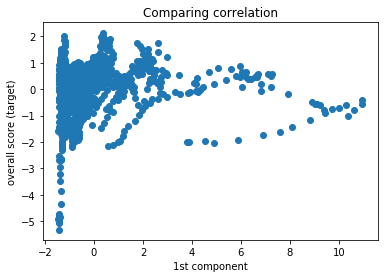

corelation of 1st component-overall score is (0.06271593320227066, 0.04256788487311672): 
corelation of 2st component-overall score is (0.22569063418567864, 1.512660472715762e-13): 
corelation of 3st component-overall score is (0.04137948276068952, 0.18113626649359066): 
corelation of 4st component-overall score is (-0.12158364781797101, 8.074411869255145e-05): 


In [32]:
# the first compenent is given by Y_sklearn[:, 0]
# visulization using scatter plot
plt.scatter(Y_sklearn[:, 0], df_fill.weighted_average_score_Z)
plt.title('Comparing correlation')
plt.ylabel('overall score (target)')
plt.xlabel('1st component')
plt.show()

for index in range(4):
    print("corelation of {}st component-overall score is {}: ".format(index+1, stats.pearsonr(Y_sklearn[:, index], df_fill.weighted_average_score_Z)))

# print("corelation of 1st component-overall score is {}: ".format(stats.pearsonr(Y_sklearn[:, 1], df_fill.weighted_average_score)))

5. If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

ANS: I would balance the importance of variance explained by principle componet vs. correlationship. And it might be based on the model to determine which is more important. I probably will have a clearer answer after I am exposed to certain specific models and have an idea what fetures certain models prefer.

# takeaways
- using interpolation to fillna is reseasonable, note that the code in solution is not what we expected to behave. When using interpolation, we need to specify columns one by one, instead feed them all in advance.

- question 5, I got it wrong. I failed to check PCA prequest that "the correlation between columns has to be not too low or too high. i.e. need to check correlation matrix between the four EXPENDITURE types. in our case, the correlation between them are over 0.7. So, PCA might not be a good choice. And we should not choose 1st principle component. 

"PCA works best for normally distributed data and assumes the relationships among variables are linear. PCA also works best when the variables involved range from weak to moderately strong correlations. Correlations of 0, or correlations greater than .7 or .8, create problems. Correlations near 0 mean there is no shared information. Correlations that are too high can result in components that are unstable and, therefore, change a lot in response to very small changes in the data or components made up of variance from only 1 or 2 variables. A few very high or very low correlations are fine. It is when we have a variable with mostly very high or very low correlations with other variables that problems can occur."

see below correlation matrix

In [35]:
# check correlation between the four EXPENDITURE types we work on.
df_fill[['INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']].corr()

,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
INSTRUCTION_EXPENDITURE,1.000000,0.975867,0.907235,0.889763
SUPPORT_SERVICES_EXPENDITURE,0.975867,1.000000,0.953789,0.913680
OTHER_EXPENDITURE,0.907235,0.953789,1.000000,0.924197
CAPITAL_OUTLAY_EXPENDITURE,0.889763,0.913680,0.924197,1.000000
